#### Assignment 7: Convolutional Neural Networks(CNN)
NOTE : PLEASE DO NOT POST/SHARE THE CODE OR YOUR SOLUTIONS ON THE WEB/GIT except CANVAS FOR GRADING

References:
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
https://www.tensorflow.org/tutorials/images/cnn
https://towardsdatascience.com/cnn-classification-a-cat-or-a-dog-568e6a135602
https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/

Description:
This assignment follows the same structure as Assignment 6. We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) using keras/tensorflow. 

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will may need some image processing.  You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation. 


Management Problem
Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?


Programming Resources
Géron, A. (2019). Hands-on machine learning with Scikit-Learn & TensorFlow: Concepts, tools, and techniques to build intelligent systems. hapter 14: Convolutional Neural Networks.Regarding memory issues. With the large number of parameters being fit in deep learning tasks, out-of-memory errors may be encountered on personal computers. Géron (2017, p. 363) provides these suggestions with regard to CNNs:
- If training crashes because of an out-of-memory error, you can try reducing the mini-batch size. Alternatively, you can try    reducing dimensionality using a stride, or removing a few layers. Or you can try using 16-bit floats instead of 32-bit floats.


Deliverables and File Formats
- Python notebook that address the problem and the writeup as indicated towards the end of this notebook (Audience:Director Data Science/Analytics)

Optional (Audience:Business/C-Suite) - Additional 20 points
1. Provide a double-spaced paper with a two-page maximum for the text. The paper in pdf format should include 
    (1) Summary and problem definition for management; 
    (2) Discussion of the methodology, data findings and traditional machine learning methods employed; 
    (3) List assumptions, programming work, issues along with model evaluation metrics; and 
    (4) Review of results/ insight swith recommendations for management.

Formatting Python Code
Refer to Google’s Python Style Guide (https://google.github.iostyleguide/pyguide.html) for ideas about formatting Python code:


NOTE : 
- Below is the starter code and please feel free to update/edit/change to provide your thoughts/solutions to the problem. 
- Comment often and in detail, highlighting major sections of code, describing the thinking behind the programming methods being employed.
- This code has a lot of errors so please make sure to updated all the cells based on best practices along with your analysis/findings.


GRADING GUIDELINES (100 points)
--------------------------------
(1) Data preparation, exploration, visualization (20 points)
(2) Review research design and modeling methods (20 points)
(3) Review results, evaluate models (20 points)
(4) Implementation and programming (20 points)
(5) Exposition, problem description, and management recommendations (20 points) 

### **Data Preparation, Exploration, Visualization**

In [1]:
import pandas as pd  # data frame operations  
import sklearn
import plotly
import plotly.graph_objs as go
import time
import numpy as np
import os
import sys
import re # regular expressions
import scipy
import seaborn as sns  # pretty plotting, including heat map
from functools import partial


# Python ≥3.5 is required
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
#S2 Mount Google Drive to Colab Enviorment
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
#S3 Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/Machine/HW7/
!pwd
!ls
print('Working Directory')
print(os.getcwd())

/content/gdrive/My Drive/Machine/HW7
/content/gdrive/My Drive/Machine/HW7
 Assignment7-GettingStarted.ipynb   test       train	   work_dir
'Copy of Assignmen.ipynb'	    test.zip   train.zip
Working Directory
/content/gdrive/My Drive/Machine/HW7


In [17]:
#Set Working direcory
work_dir = "/content/gdrive/MyDrive/Machine/HW7"

In [18]:
# !unzip train.zip -d work_dir > /dev/null

In [19]:
import cv2, random

In [20]:
# Working Directory
TRAIN_DIR = work_dir + '/train/'
TEST_DIR = work_dir + '/test/'

ROWS = 224
COLS = 224
CHANNELS = 3

# Read in dataset to dogs and cat
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# Only using 3000 for each category because colab GPU limit
train_images = train_dogs[:3000] + train_cats[:3000]
random.shuffle(train_images)
test_images =  test_images

# Read in images
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img,(ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS,
                       ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 6000
Processed 250 of 6000
Processed 500 of 6000
Processed 750 of 6000
Processed 1000 of 6000
Processed 1250 of 6000
Processed 1500 of 6000
Processed 1750 of 6000
Processed 2000 of 6000
Processed 2250 of 6000
Processed 2500 of 6000
Processed 2750 of 6000
Processed 3000 of 6000
Processed 3250 of 6000
Processed 3500 of 6000
Processed 3750 of 6000
Processed 4000 of 6000
Processed 4250 of 6000
Processed 4500 of 6000
Processed 4750 of 6000
Processed 5000 of 6000
Processed 5250 of 6000
Processed 5500 of 6000
Processed 5750 of 6000
Processed 0 of 12500
Processed 250 of 12500
Processed 500 of 12500
Processed 750 of 12500
Processed 1000 of 12500
Processed 1250 of 12500
Processed 1500 of 12500
Processed 1750 of 12500
Processed 2000 of 12500
Processed 2250 of 12500
Processed 2500 of 12500
Processed 2750 of 12500
Processed 3000 of 12500
Processed 3250 of 12500
Processed 3500 of 12500
Processed 3750 of 12500
Processed 4000 of 12500
Processed 4250 of 12500
Processed 4500 of 12500
Proc

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



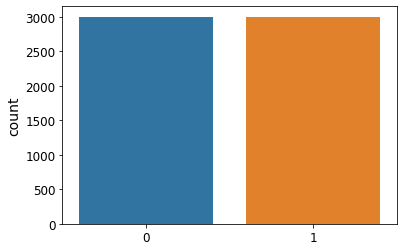

In [21]:
# Check the distribution of dogs and cats
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
sns.countplot(labels)

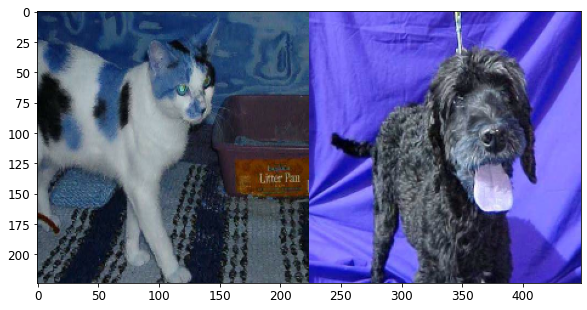

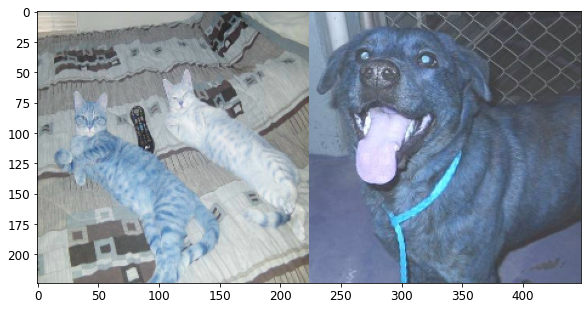

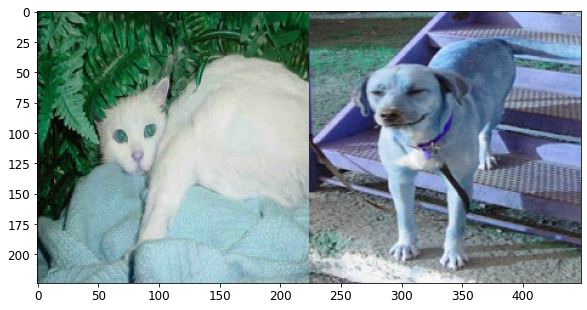

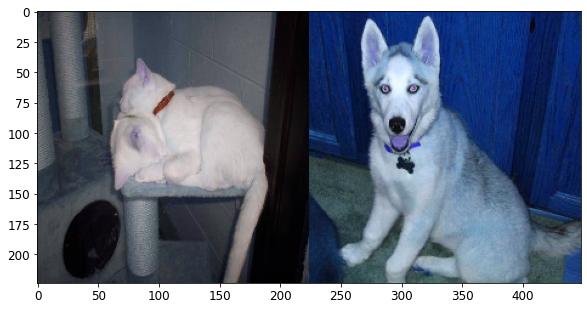

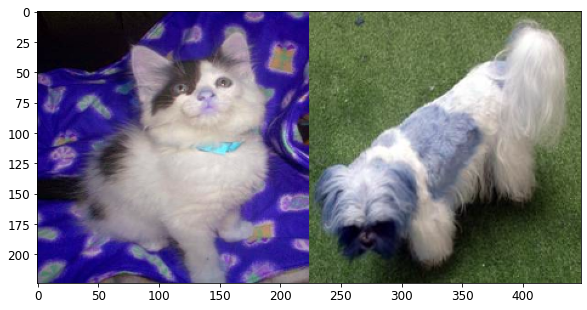

In [22]:
# Display Images
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

Text(0.5, 1.0, 'Average Dog')

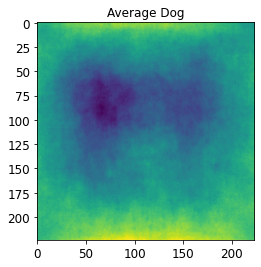

In [23]:
# Check the average dog and cat
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Average Dog')

Text(0.5, 1.0, 'Average Cat')

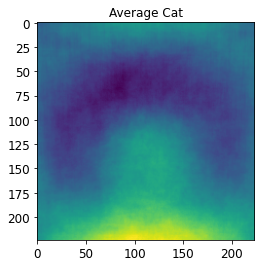

In [24]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Average Cat')

# Saving Loaded data for future use

In [33]:
np.save('train_data.npy', train)

In [34]:
np.save('train_data.npy', test)

### **Model Building**

In [25]:
# Importing keras for CNN
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [26]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(filters = 32, kernel_size = (3), padding = 'valid',input_shape=(3, ROWS, COLS), activation='relu', data_format='channels_first'))
    model.add(Convolution2D(filters = 32, kernel_size = (3), padding = 'valid',activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(filters =64, kernel_size = (3),  padding = 'valid',activation='relu', data_format='channels_first'))
    model.add(Convolution2D(filters =64, kernel_size = (3),  padding = 'valid',activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, kernel_size = (3),  padding = 'valid',activation='relu', data_format='channels_first'))
    model.add(Convolution2D(128, kernel_size = (3), padding = 'valid', activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

In [27]:
labels = np.asarray(labels)

### **Testing and Validations**

In [28]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

Epoch 00007: early stopping


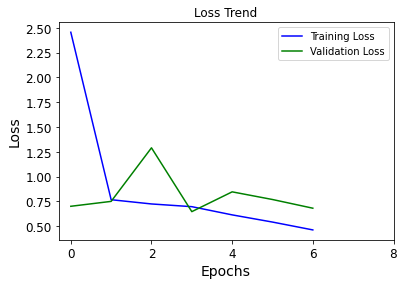

In [29]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

Both the training and validation loss is decreasing, so this means that the model is actually converging. The Validation loss actually increases between a few epochs, and this might be a problem of overfitting.

53.74% this is a Dog


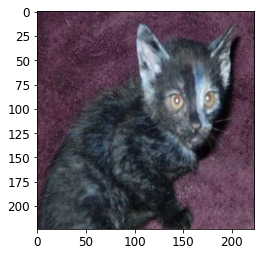

59.88% this is a Cat


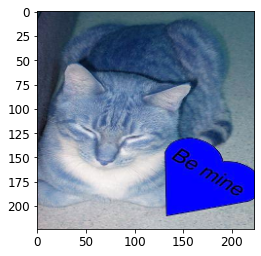

83.57% this is a Dog


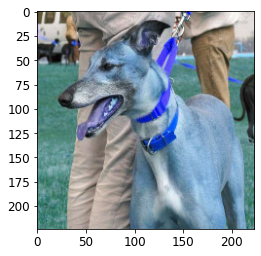

71.13% this is a Cat


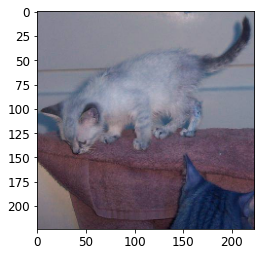

68.62% this is a Cat


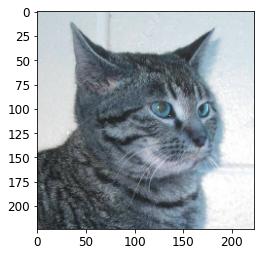

In [30]:
# Chcek some of the predictions
for i in range(0,5):
    if predictions[i, 0] >= 0.5: 
        print('{:.2%} this is a Dog'.format(predictions[i][0]))
    else: 
        print('{:.2%} this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()

In [31]:
predictions.shape

(12500, 1)

In [32]:
# Prepare csv for kaggle and submit
kag_1 = pd.DataFrame(predictions, range(1,12501))
kag_1.reset_index(inplace = True)

kag_1.columns = ['id','label']
kag_1.to_csv('kag_1.csv', index = False)

I submitted my reuslt to Kaggle, and got a score of 1.35360
my userid is RenjieLiu

### **Adding more layers to the model**

In [35]:
# Adding more layers to make the model more complex
def catdog2():
    
    model = Sequential()

    model.add(Convolution2D(32, (3, 3), padding='valid', input_shape=(3, ROWS, COLS), activation='relu',data_format='channels_first'))
    model.add(Convolution2D(32, (3, 3), padding='valid', activation='relu',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3, 3), padding='valid', activation='relu',data_format='channels_first'))
    model.add(Convolution2D(64, (3, 3), padding='valid', activation='relu',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, (3, 3), padding='valid', activation='relu',data_format='channels_first'))
    model.add(Convolution2D(128, (3, 3), padding='valid', activation='relu',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, (3, 3), padding='valid', activation='relu',data_format='channels_first'))
    model.add(Convolution2D(256, (3, 3), padding='valid', activation='relu',data_format='channels_first'))
    model.add(Convolution2D(256, (3, 3), padding='valid', activation='relu',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=[['accuracy', 'mse']])
    return model


model2 = catdog2()

In [36]:
nb_epoch = 20
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor= 'loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model2.fit(train, labels, batch_size=batch_size, validation_split = 0.3, epochs=nb_epoch,verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions2 = model2.predict(test, verbose=0)
    return predictions2, history

predictions2, history = run_catdog()

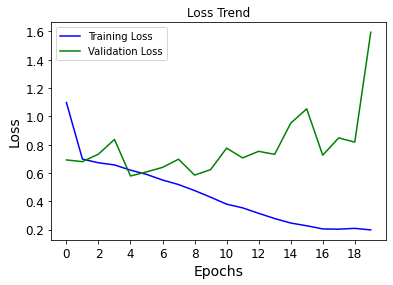

In [37]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [41]:
# Prepare csv for kaggle and submit
kag_2 = pd.DataFrame(predictions2, range(1,12501))
kag_2.reset_index(inplace = True)

kag_2.columns = ['id','label']
kag_2.to_csv('kag_2.csv', index = False)

I submitted to kaggle and i got a score of 4.42852.

The more complex model actually has a higher score, but this means that the new model is considered worse than the simpler model. From the plot we can also see that the loss is actually increasing, so this means that the model is overfitting the dataset. Therefore, i will try to make the model more simple to lower the socre for kaggle.

### **Trying a simpler model than the first model**

In [42]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog3():
    
    model = Sequential()

    model.add(Convolution2D(filters = 32, kernel_size = (3), padding = 'valid',input_shape=(3, ROWS, COLS), activation='relu', data_format='channels_first'))
    model.add(Convolution2D(filters = 32, kernel_size = (3), padding = 'valid',activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(filters =64, kernel_size = (3),  padding = 'valid',activation='relu', data_format='channels_first'))
    model.add(Convolution2D(filters =64, kernel_size = (3),  padding = 'valid',activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog3()

In [44]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions3 = model.predict(test, verbose=0)
    return predictions3, history

predictions3, history = run_catdog()

Epoch 00004: early stopping


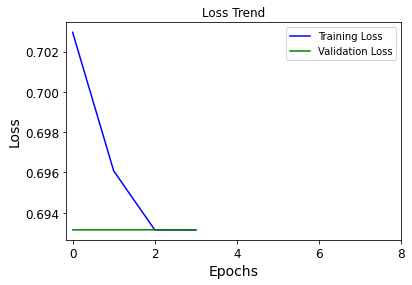

In [45]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [47]:
# Prepare csv for kaggle and submit
kag_3 = pd.DataFrame(predictions3, range(1,12501))
kag_3.reset_index(inplace = True)

kag_3.columns = ['id','label']
kag_3.to_csv('kag_3.csv', index = False)

I submitted to kaggle and got a score of 0.69310. This is the best score so far, so it means that the simpler model is actually working. The loss plot also looks the best since the train loss and validation loss are converging, and this means that there is no problem of overfitting.

### **Summary**

In this assignment, I used CNN to classifiy the image category. I first transfomred the image to np arrary, so it can be used to train the cnn. Then I build a basic CNN, and fit the model. The loss plot dose not look very promising, so I tried to add more layers to increase the complexity of the model, but it did not work since the loss score actually increases, and it means that the model is not as good as the frist one. In the end, I tried to use a simpler model, and it got a lower log loss on kaggle, so this means that the model is better than the other two models. Therefore, this will be my final model used to classify the images.

work Cited:

https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter

https://www.kaggle.com/shivamb/cnn-architectures-vgg-resnet-inception-tl

https://www.kaggle.com/sentdex/full-classification-example-with-convnet
